In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import sys
sys.path.append("../")
from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from functools import partial
import optax
from lru.analysis import *
from lru.dataloaders.regression import *
from lru.train_helpers import loss_fn
from lru.model import LRU, RNN, S4
import pandas as pd
from utils import *
from mpl_toolkits.axes_grid1 import make_axes_locatable

from hessian_plot_utils import *
import set_rcParams

batch_size = 64
seq_len = 300
input_dim = 1
hidden_dim = 4
output_dim = 1
seed = 0

In [3]:
def hessian(model, params, X, Y, masks):
    p, unravel = ravel_pytree(params)
    safe_unravel = lambda p: jax.tree_util.tree_map(lambda x: x.astype(p.dtype), unravel(p))

    @jax.jit
    def loss(p):
        pred = model.apply(safe_unravel(p), X)
        return loss_fn(pred, Y, masks)
    
    hess = jax.hessian(loss)(p)
    return hess

In [4]:
# Issue: dataset generates real valued eigvenvalues only when d_hidden = 10 so we generate things by hand
# in this setting
keys = jax.random.split(jax.random.PRNGKey(seed), 4)
diag = (0.99 + 0.003 * jax.random.uniform(keys[0], (2, ))) * np.exp(2j * np.pi * jax.random.uniform(keys[1], (2, )))
diag = jnp.concatenate([diag, diag.conjugate()])
U = jax.random.normal(keys[2], (2, 4)) / 2 / np.sqrt(2) + 1j * jax.random.normal(keys[3], (2, 4)) / 2 / np.sqrt(2)
U = np.concatenate([U, U.conjugate()], axis=0)
A = (np.linalg.inv(U) @ np.diag(diag) @ U).real

dataset = LinearSystem(seed, input_dim, hidden_dim, output_dim, seq_len, parametrization="dense", min_nu=0.98, max_nu=0.992, use_B_C_D=True, max_phase=3.14)
dataset.A = A

CUDA backend failed to initialize: jaxlib/cuda/versions_helpers.cc:98: operation cuInit(0) failed: CUDA_ERROR_NO_DEVICE (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
loader = RegressionDataLoader(dataset, seed + 1, batch_size, 1000)
X, Y, masks = next(iter(loader))

model = RNN(hidden_dim, output_dim, min_nu=0., max_nu=1., use_B_C_D=True)
p = model.init(jax.random.PRNGKey(2), X)

p["params"]["A"] = dataset.A
p["params"]["B"]["kernel"] = dataset.B.T
p["params"]["C"]["kernel"] = dataset.C.T
p["params"]["D"]["kernel"] = dataset.D

print("Loss", loss_fn(model.apply(p, X), Y, masks))

H_linear_RNN = hessian(model, p, X, Y, masks)
size_A = np.prod(dataset.A.shape)
size_B = np.prod(dataset.B.shape)
size_C = np.prod(dataset.C.shape)
size_D = np.prod(dataset.D.shape)
sizes_linear_RNN = [size_A, size_B, size_C, size_D]
pads_linear_RNN = [3, 3, 3]
legends_RNN = ["A", "B", "C", "D"]

Loss 1.3685320689446479e-27


In [6]:
class FakeLRU():  # to have the params plotted in the same order as in the linear RNN
    def __init__(self, lru):
        self.lru = lru
    def apply(self, p, X):
        lru_param = {"params": {
            "lambda": jnp.stack([p["params"]["A_re"], p["params"]["A_im"]]),
            "B_re": p["params"]["B_re"],
            "B_im": p["params"]["B_im"],
            "C_re": p["params"]["C_re"],
            "C_im": p["params"]["C_im"],
            "D": p["params"]["D"],
        }}
        return self.lru.apply(lru_param, X)


model = LRU(input_dim, hidden_dim, output_dim, min_nu=0.95, max_nu=0.99, which_gamma="none", parametrization="default")
p = model.init(jax.random.PRNGKey(2), X)
model = FakeLRU(model)

d, U = np.linalg.eig(dataset.A)

new_B = jnp.linalg.inv(U) @ dataset.B
p["params"]["B_re"] = new_B.real
p["params"]["B_im"] = new_B.imag
new_C = dataset.C @ U
p["params"]["C_re"] = new_C.real
p["params"]["C_im"] = new_C.imag
p["params"]["D"] = dataset.D
p["params"]["A_re"] = d.real
p["params"]["A_im"] = d.imag
# remove key lambda
p["params"] = {k: v for k, v in p["params"].items() if k != "lambda"}

print("Loss", loss_fn(model.apply(p, X), Y, masks))


size_B_im = np.prod(new_B.imag.shape)
size_B_re = np.prod(new_B.real.shape)
size_C_im = np.prod(new_C.imag.shape)
size_C_re = np.prod(new_C.real.shape)
size_D = np.prod(dataset.D.shape)
size_lambda_real = np.prod(p["params"]["A_re"].shape)
size_lambda_imag = np.prod(p["params"]["A_im"].shape)
sizes_LRU = [size_lambda_real, size_lambda_imag, size_B_re, size_B_im, size_C_re, size_C_im, size_D]
pads_LRU = [1, 2, 1, 2, 1, 2]
legends_LRU = [r"$\lambda^\mathrm{re}$", "$\lambda^\mathrm{im}$", "B$^\mathrm{re}$", r"B$^\mathrm{im}$", r"C$^\mathrm{re}$", r"C$^\mathrm{im}$", "D"]

H_LRU = hessian(model, p, X, Y, masks)

Loss 2.10883719027721e-25


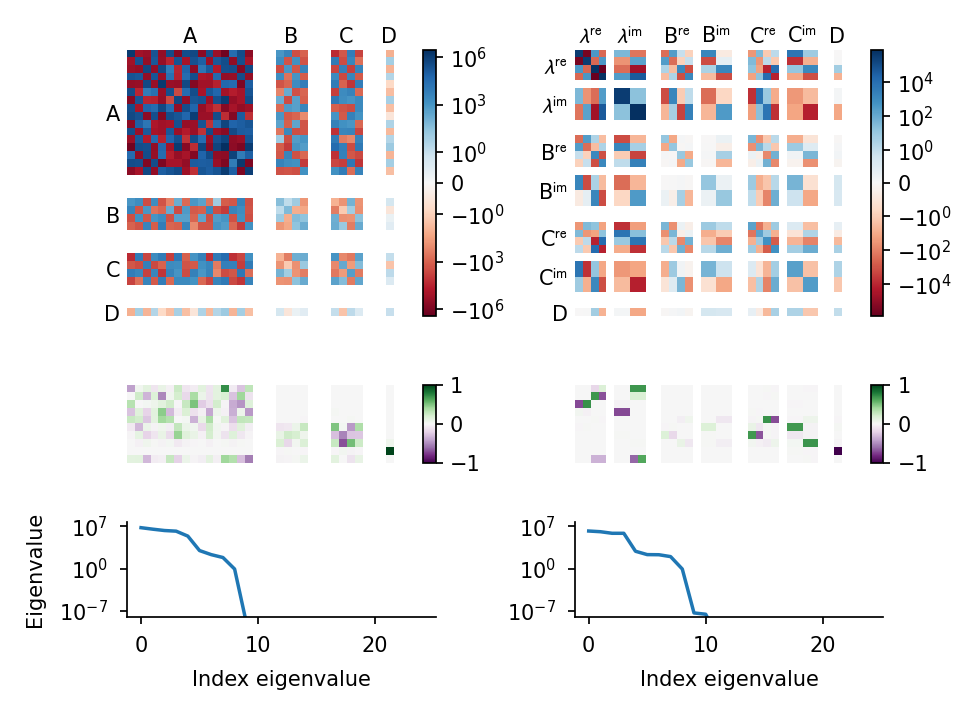

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(4, 3), gridspec_kw={"height_ratios": [3, 1, 1]})

max_eigval = 0

extended_H, positions, eigvals, extended_eigvects = extend_hessian(H_linear_RNN, sizes_linear_RNN, pads_linear_RNN)
plot(ax, positions, legends_RNN, extended_H, extended_eigvects, eigvals, 0)
max_eigval = max(max_eigval, eigvals.max())
extended_H, positions, eigvals, extended_eigvects = extend_hessian(H_LRU, sizes_LRU, pads_LRU)
plot(ax, positions, legends_LRU, extended_H, extended_eigvects, eigvals, 1)
max_eigval = max(max_eigval, eigvals.max())

ax[2, 0].set_ylim(1e-8, 10 * max_eigval)
ax[2, 1].set_ylim(1e-8, 10 * max_eigval)
ax[2, 0].set_yticks([1e-7, 1, 1e7])
ax[2, 1].set_yticks([1e-7, 1, 1e7])

plt.tight_layout()

plt.savefig("raw/RNNs_figure4_raw_p1.pdf")

### Appendix: the one for the LRU and S4

In [8]:
class FakeLRU():  # to have the params plotted in the same order as in the linear RNN
    def __init__(self, lru):
        self.lru = lru
    def apply(self, p, X):
        lru_param = {"params": {
            "lambda": jnp.stack([p["params"]["A_nu"], p["params"]["A_theta"]]),
            "gamma": p["params"]["A_zgamma"],
            "B_re": p["params"]["B_re"],
            "B_im": p["params"]["B_im"],
            "C_re": p["params"]["C_re"],
            "C_im": p["params"]["C_im"],
            "D": p["params"]["D"],
        }}
        return self.lru.apply(lru_param, X)


model = LRU(input_dim, hidden_dim, output_dim, min_nu=0.95, max_nu=0.99, which_gamma="learned", parametrization="exp")
p = model.init(jax.random.PRNGKey(2), X)
model = FakeLRU(model)

d, U = np.linalg.eig(dataset.A)

new_B = jnp.linalg.inv(U) @ dataset.B
gamma = jnp.sqrt(1 - jnp.abs(d) ** 2)
p["params"]["B_re"] = jnp.diag(1 / gamma) @ new_B.real
p["params"]["B_im"] = jnp.diag(1 / gamma) @ new_B.imag
p["params"]["A_zgamma"] = jnp.log(gamma)
new_C = dataset.C @ U
p["params"]["C_re"] = new_C.real
p["params"]["C_im"] = new_C.imag
p["params"]["D"] = dataset.D
p["params"]["A_nu"] = jnp.log(-jnp.log(jnp.abs(d)))
p["params"]["A_theta"] = jnp.log(jnp.mod(jnp.angle(d), 2 * jnp.pi))
p["params"] = {k: v for k, v in p["params"].items() if k != "lambda"}

print("Loss", loss_fn(model.apply(p, X), Y, masks))


size_B_im = np.prod(new_B.imag.shape)
size_B_re = np.prod(new_B.real.shape)
size_C_im = np.prod(new_C.imag.shape)
size_C_re = np.prod(new_C.real.shape)
size_D = np.prod(dataset.D.shape)
size_nu = np.prod(p["params"]["A_nu"].shape)
size_theta = np.prod(p["params"]["A_theta"].shape)
size_gamma = np.prod(p["params"]["A_zgamma"].shape)
sizes_LRU = [size_nu, size_theta, size_gamma, size_B_re, size_B_im, size_C_re, size_C_im, size_D]
pads_LRU = [1] * (len(sizes_LRU) - 1)
legends_LRU = [r"$\omega_\nu$", r"$\omega_\theta$", r"$\omega_\gamma$", "B$^\mathrm{re}$", r"B$^\mathrm{im}$", r"C$^\mathrm{re}$", r"C$^\mathrm{im}$", "D"]

H_LRU = hessian(model, p, X, Y, masks)

Loss 3.405114390938588e-25


/home/nicolas/Identification-linear-systems-with-RNNs/env/lib/python3.10/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


In [13]:
class FakeS4():  # to have the params plotted in the same order as in the linear RNN
    def __init__(self, s4):
        self.s4 = s4
    def apply(self, p, X):
        s4_param = {"params": {
            "A": jnp.stack([p["params"]["A_are"][None, :], p["params"]["A_bim"][None, :]]),
            "Delta": p["params"]["A_zDelta"],
            "B_re": p["params"]["B_re"],
            "B_im": p["params"]["B_im"],
            "C_re": p["params"]["C_re"],
            "C_im": p["params"]["C_im"],
            "D": p["params"]["D"],
        }}
        return self.s4.apply(s4_param, X)


model = S4(input_dim, hidden_dim, min_nu=0.95, max_nu=0.99, shared_Delta=False)
p = model.init(jax.random.PRNGKey(2), X)
model = FakeS4(model)

d, U = np.linalg.eig(dataset.A)

Delta = 0.01
new_B = jnp.linalg.inv(U) @ dataset.B
p["params"]["B_re"] = new_B.real.T / Delta
p["params"]["B_im"] = new_B.imag.T / Delta
new_C = dataset.C @ U
p["params"]["C_re"] = new_C.real
p["params"]["C_im"] = new_C.imag
p["params"]["D"] = dataset.D[0]
p["params"]["A_are"] = jnp.log(jnp.abs(d)) / Delta
p["params"]["A_bim"] = jnp.mod(jnp.angle(d), 2 * jnp.pi) / Delta
inv_softplus = lambda x: jnp.log(jnp.exp(x) - 1)
p["params"]["A_zDelta"] = inv_softplus(Delta * jnp.ones_like(d, dtype=jnp.float32))
p["params"] = {k: v for k, v in p["params"].items() if k != "A"}

print("Loss", loss_fn(model.apply(p, X), Y, masks))

size_B_im = np.prod(new_B.imag.shape)
size_B_re = np.prod(new_B.real.shape)
size_C_im = np.prod(new_C.imag.shape)
size_C_re = np.prod(new_C.real.shape)
size_D = np.prod(dataset.D.shape)
size_nu = np.prod(p["params"]["A_are"].shape)
size_theta = np.prod(p["params"]["A_bim"].shape)
size_gamma = np.prod(p["params"]["A_zDelta"].shape)
sizes_S4 = [size_nu, size_theta, size_gamma, size_B_re, size_B_im, size_C_re, size_C_im, size_D]
pads_S4 = [1] * (len(sizes_LRU) - 1)
legends_S4 = [r"$\omega_A^\mathrm{re}$", r"$\omega_A^\mathrm{im}$", r"$\omega_\Delta$", "B$^\mathrm{re}$", r"B$^\mathrm{im}$", r"C$^\mathrm{re}$", r"C$^\mathrm{im}$", "D"]

H_S4 = hessian(model, p, X, Y, masks)

Loss 1.7615976702738794e-06


/home/nicolas/Identification-linear-systems-with-RNNs/env/lib/python3.10/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


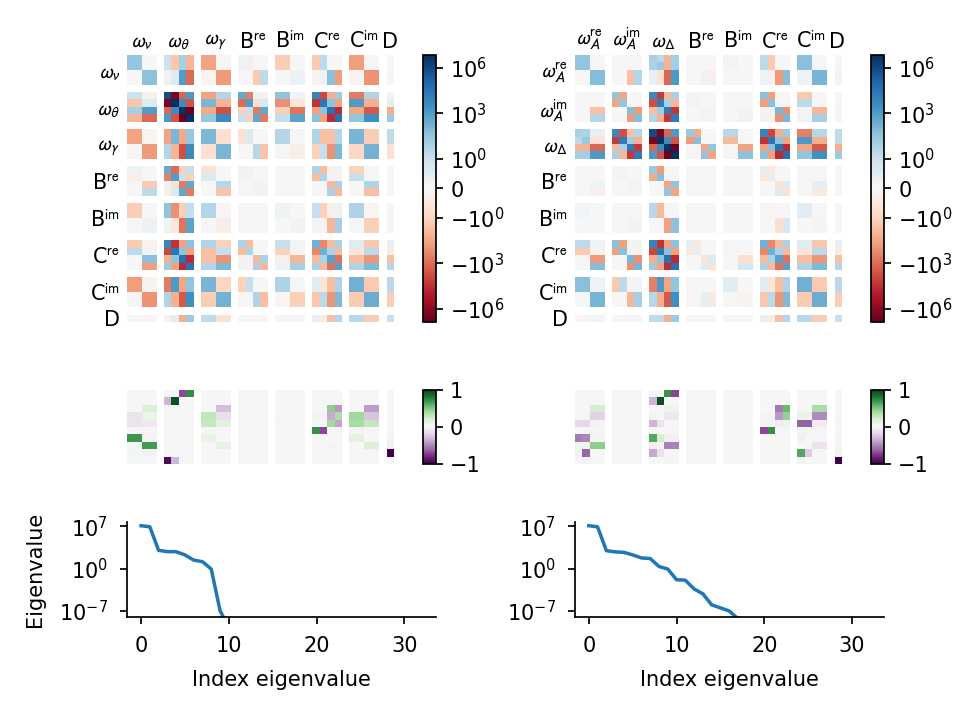

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(4, 3), gridspec_kw={"height_ratios": [3, 1, 1]})


extended_H, positions, eigvals, extended_eigvects = extend_hessian(H_LRU, sizes_LRU, pads_LRU)
plot(ax, positions, legends_LRU, extended_H, extended_eigvects, eigvals, 0)
extended_H, positions, eigvals, extended_eigvects = extend_hessian(H_S4, sizes_S4, pads_S4)
plot(ax, positions, legends_S4, extended_H, extended_eigvects, eigvals, 1)
ax[2, 0].set_ylim(1e-8, 10 * max_eigval)
ax[2, 1].set_ylim(1e-8, 10 * max_eigval)
ax[2, 0].set_yticks([1e-7, 1, 1e7])
ax[2, 1].set_yticks([1e-7, 1, 1e7])

plt.tight_layout()

plt.savefig("raw/RNNs_figureE_raw_p1.pdf")